## Data preparation
Rastrigin-200d with 200 initial data

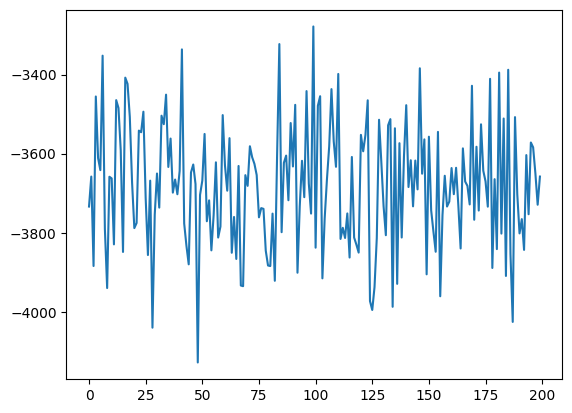

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random


def true_oracle(x, n):
    #n = len(x)
    A = 10
    return -(A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x)))


# Set the random seed for reproducibility
random.seed(42)

# Generate 2000 arrays of size 100 with integers from 0 to 50
num_arrays = 200
array_size = 200
random_coefficient =0.8
X = [[random.randint(-50, 50)/10 for _ in range(array_size)] for _ in range(num_arrays)]
X = np.array(X)
y = []
for i in X:
  y.append(true_oracle(i,array_size))
y = np.array(y)

plt.plot(y)



## Define the CNN model

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import mean_squared_error
def model_training(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model = Sequential()
  model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='elu', input_shape=(array_size, 1)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='elu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='elu'))
  model.add(MaxPooling1D(pool_size=2, strides=1))
  model.add(Conv1D(16, kernel_size=3, strides=1, padding='same', activation='elu'))
  model.add(Conv1D(8, kernel_size=3, strides=1, padding='same', activation='elu'))
  model.add(Conv1D(4, kernel_size=3, strides=1, padding='same', activation='elu'))
  model.add(Flatten())
  model.add(Dense(64,activation='elu'))
  model.add(Dense(1,activation='linear'))
  print(model.summary())

  early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  # Define learning rate decay function
  def lr_decay(epoch):
      initial_lr = 0.001
      decay_rate = 0.1
      decay_steps = 5
      new_lr = initial_lr * (decay_rate ** (epoch // decay_steps))
      return new_lr

  lr_decay_callback = LearningRateScheduler(lr_decay)
  model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_percentage_error')
  model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stop])
  return model,X_test,y_test



##Define the DOTS algorithm

In [3]:
from abc import ABC, abstractmethod
from collections import defaultdict
import math

class DOTS:
    "DOTS"
    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node, model):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            print('not seen before, randomly sampled!')
            return node.find_random_child()

        def evaluate(n):
            return n.value  # average reward
        print(f'number of visit is {self.N[node]}')
        log_N_vertex = math.log(self.N[node])
        def uct(n):
            "Dynamic upper confidence bound "
            uct_value = n.value + self.exploration_weight * math.sqrt(
                log_N_vertex / (self.N[n]+1))
            return uct_value
        media_node = max(self.children[node], key=uct)

        rand_index = random.randint(0, len(list(self.children[node]))-1)
        node_rand = list(self.children[node])[rand_index]
        print(f'uct of the node is{uct(node)} ')
        if uct(media_node) > uct(node):
            print(f'better uct media node : {uct(media_node)}')
            print(f'better value media node : {media_node.value}')
            return media_node, node_rand
        print('node stays!')
        return node, node_rand

    def do_rollout(self, node,model):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf,model)
        reward = self._simulate(leaf,model)
        self._backpropagate(path, reward)

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
              return path
            unexplored = self.children[node] - self.children.keys()
            def evaluate(n):
              return n.value
            if unexplored:
              #n= unexplored.pop()
              path.append(max(unexplored, key=evaluate))#
              return path
            node = self._uct_select(node)  # descend a layer deeper


    def _expand(self, node,model):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded

        action = [p for p in range(0, len(node.tup))]
        self.children[node] = node.find_children(action,model)

    def _simulate(self, node,model):
        "Returns the reward for a random simulation (to completion) of `node`"
        reward = node.reward(model)
        return reward


    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
          self.N[node] += 1
          self.Q[node] += reward
            #reward = 1 - reward  # 1 for me is 0 for my enemy, and vice versa

    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = math.log(self.N[node])


        def uct(n):
            "Dynamic pper confidence bound"
            uct_value = n.value + self.exploration_weight * math.sqrt(
                log_N_vertex / (self.N[n] + 1))
            return uct_value
        uct_node = max(self.children[node], key=uct)
        print(f'node with max uct is:{uct_node}')
        return uct_node

class Node(ABC):
    """
    A representation of a single board state.
    DOTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """

    @abstractmethod
    def find_children(self):
        "All possible successors of this board state"
        return set()

    @abstractmethod
    def find_random_child(self):
        "Random successor of this board state (for more efficient simulation)"
        return None

    @abstractmethod
    def is_terminal(self):
        "Returns True if the node has no children"
        return True

    @abstractmethod
    def reward(self):
        "Assumes `self` is terminal node. 1=win, 0=loss, .5=tie, etc"
        return 0

    @abstractmethod
    def __hash__(self):
        "Nodes must be hashable"
        return 123456789

    @abstractmethod
    def __eq__(node1, node2):
        "Nodes must be comparable"
        return True


from collections import namedtuple
from random import choice

def oracle(x,model):
    #print(f'x is {x}')
    try:
       pred = model.predict(np.array(x).reshape(len(x),array_size))
    except:
       pred = model.predict(np.array(x).reshape(1,array_size))

    return pred

_OT = namedtuple("opt_task", "tup value terminal")
class opt_task(_OT, Node):
    def find_children(board,action,model):
        if board.terminal:
            return set()
        turn = 0.1
        all_tup=[]
        for index in action:
            tup = list(board.tup)
            flip = random.randint(0,5)
            if   flip ==0:
              tup[index] += turn
            elif flip ==1:
                tup[index] -= turn
            elif flip ==2:
              for i in range(int(array_size/5)):
                index_2 = random.randint(0, len(tup)-1)
                tup[index_2] = random.randint(-100, 100)/10
            elif flip ==3:
              for i in range(int(array_size/10)):
                index_2 = random.randint(0, len(tup)-1)
                tup[index_2] = random.randint(-100, 100)/10
            elif flip ==4:
              tup[index] = random.randint(-100, 100)/10
            else:
              tup[index] = random.randint(-100, 100)/10
            tup[index] = round(tup[index],2)
            all_tup.append(tup)
        all_value = oracle(all_tup, model)
        all_item= []
        is_terminal=False

        return  {opt_task(tuple(t), v[0], is_terminal) for t, v in  zip(all_tup,all_value)}

    def reward(board,model):
        return  oracle(board.tup, model)[0][0] #round(10/(true_oracle(np.array(board.tup),len(board.tup))+0.01),5)
    def is_terminal(board):
        return board.terminal



# Utility functions

In [4]:
def analysis(tree_ubt):
  all_visits = tree_ubt.N
  childrens = [i for i in tree_ubt.children]
  childrens_tup = [np.array(i.tup) for i in tree_ubt.children]
  children_N = [all_visits[i] for i in tree_ubt.children]

  print(f'number of childrens are {len(childrens)}')
  import matplotlib.pyplot as plt
  plt.figure()
  plt.hist(all_visits.values())
  plt.xlim([1,20])
  plt.ylim([0,100])

  top_n = 10
  ind = np.argpartition(children_N, -top_n)[-top_n:]
  top_childrens = [list(childrens[i].tup) for i  in ind]
  N  =  [children_N[i] for i  in ind]

  return N,top_childrens
def most_visit_node(tree_ubt, X, top_n):
  N_visit = tree_ubt.N
  childrens = [i for i in tree_ubt.children]
  children_N = []
  X_top = []
  for child in childrens:
    child_tup = np.array(child.tup)
    same = np.all(child_tup==X, axis=1)
    has_true = any(same)
    if has_true == False:
      children_N.append(N_visit[child])
      X_top.append(child_tup)
  children_N = np.array(children_N)
  X_top = np.array(X_top)
  ind = np.argpartition(children_N, -top_n)[-top_n:]
  X_topN = X_top[ind]
  topN = children_N[ind]
  print(f'Top N is {topN}')
  return X_topN

def random_node(new_rands, n):
  X_rand1 = [new_rands[random.randint(0, len(new_rands)-1)] for i in range(n)]
  return X_rand1

def single_run(X,y,model,initial_X,top_n,top_visit,rand, greedy_UCT, UCT_low):
  if greedy_UCT== True:
      values = max(y)
  exp_weight = 1*abs(values)
  if UCT_low ==True:
      values = model.predict(np.array(initial_X).reshape(1,array_size))[0][0]
      exp_weight = 0.5*abs(values)
  board_uct = opt_task(tup=tuple(initial_X), value=values, terminal=False)

  rollout_round = 100
  dots = DOTS(exploration_weight=exp_weight)
  dots.do_rollout(board_uct,model)
  board_uct,board_rand = dots.choose(board_uct,model)
  boards = []
  boards_rand = []
  for i in range(rollout_round):
      print(i)
      print(f'new board is {board_uct}')
      dots.do_rollout(board_uct,model)
      board_uct,board_rand = dots.choose(board_uct,model)
      boards.append(list(board_uct.tup))
      boards_rand.append(list(board_rand.tup))
  new_x = []
  new_pred = []
  boards = np.array(boards)
  boards = np.unique(boards, axis=0)
  pred_values = oracle(boards, model)
  for i,j in zip(boards,pred_values):
    temp_x = np.array(i)
    same = np.all(temp_x==X, axis=1)
    has_true = any(same)
    if has_true == False:
      new_pred.append(j[0])
      new_x.append(temp_x)
  new_x= np.array(new_x)
  new_pred = np.array(new_pred)
  ind = np.argpartition(new_pred, -top_n)[-top_n:]
  top_prediction =  new_x[ind]
  X_most_visit =  most_visit_node(dots, X,top_visit)
  X_rand_node =  random_node(new_x,rand)
  X_next = np.concatenate([top_prediction,X_most_visit,X_rand_node])
  final_pred =  X_next


  y_next = []
  for i in X_next:
      y_next.append(true_oracle(i,array_size))
  y_next = np.array(y_next)

  return dots, X_next, y_next, exp_weight

In [5]:
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import explained_variance_score,mean_squared_error

top_select = 3
top_pre = 5
top_visit = 1
rand = 1

def run(X,y,  UCT_low):
  greedy_UCT = True
  model,X_test,y_test = model_training(X,y)
  y_pred = model.predict(X_test)
  y_temp = [i[0] for i in y_pred]

  p_r,_= pearsonr(np.array(y_temp),y_test)
  var = explained_variance_score(np.array(y_temp),y_test)

  mse = mean_squared_error(y_pred,y_test)
  print(f'mse is {mse}')
  print(f'variance is {var}')
  ind = np.argpartition(y, -top_select)[-top_select:]
  x_current_top = X[ind]
  y_top=[]
  X_top=[]
  top_selections = []
  N_total = []
  childrens_TopN = []
  for i in range (top_select):
    top_temp = x_current_top[i]
    tree_dots, x_0, y_0, exp_weight = single_run(X,y,model,top_temp,top_pre, top_visit, rand, greedy_UCT, UCT_low)
    y_top.append(y_0)
    X_top.append(x_0)
    top_selections.append(top_temp)
    N,top_childrens = analysis(tree_dots)
    print(f'top 10 N are {N}')
    print(f'top 10 children are {top_childrens }')

  X_top = np.vstack(X_top)
  y_top = np.array(y_top).reshape(-1)
  X_r2 = np.concatenate([X, X_top])
  y_r2 = np.concatenate([y, y_top])


  print(f'pearson ratio is {p_r}')
  print(f'mse is {mse}')
  print(f'variance is {var}')
  print(f'exp_weight is {exp_weight}')
  print(f'total number of data: {len(X_r2)}')
  print(f'top x are {top_selections}')
  print(f'true value of  top x are {y[ind]}')

  print(f'top selection are {X_top}')
  print(f'true value of  selection are {y_top}')
  plt.figure()
  sns.regplot(x=y_pred,y=y_test)
  plt.title('CNN model performance')
  plt.figure()
  plt.hist(y)
  plt.hist(y_r2[-10:])
  plt.xlim([0.2*max(y_r2),1.1*max(y_r2)])
  plt.title('ground truth distribution')

  return X_r2,y_r2

# round #1
Here we select low exploration value as example


By default, DOTS performs 100 rollout


Explore low has been set to 'low', in this case exploration weights = 0.5


Input description:
*   X: initial data
*   y: initial label



Output description:

*   X_r2: initial data + newly sampled data
*   y_r2: iniital labels + new labels

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 200, 128)          512       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 100, 128)          0         
 g1D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 100, 128)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 100, 64)           24640     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 50, 64)            0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 50, 64)           

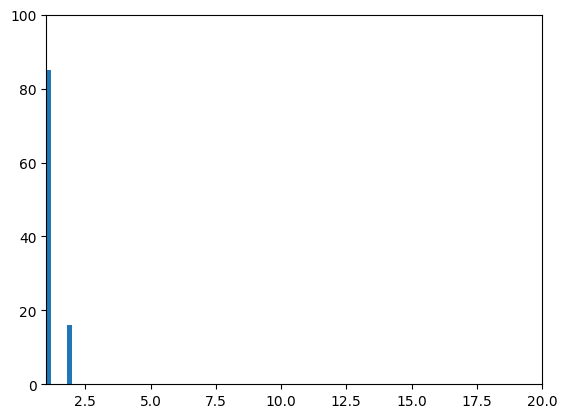

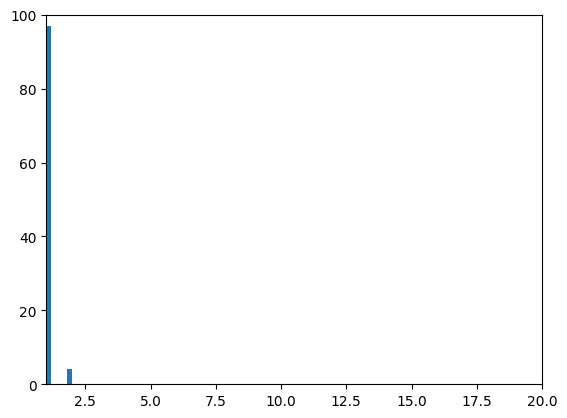

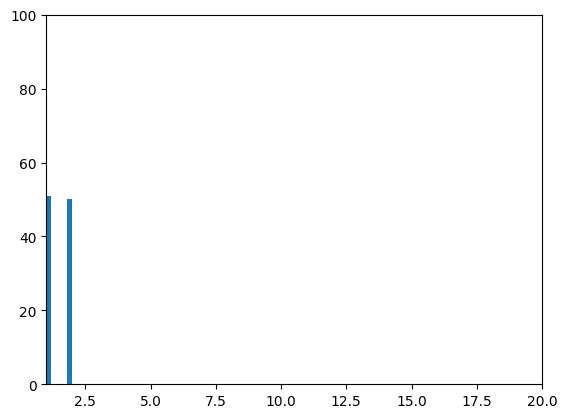

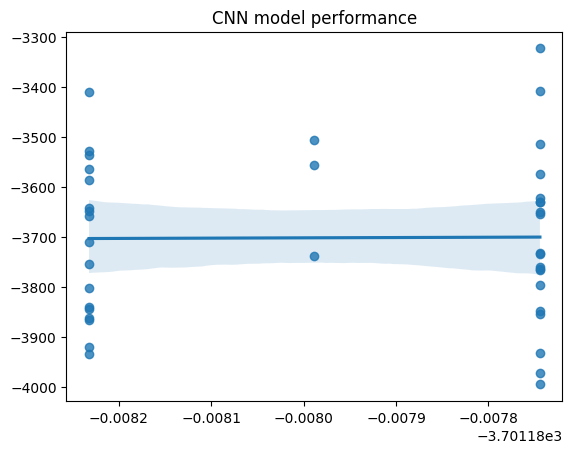

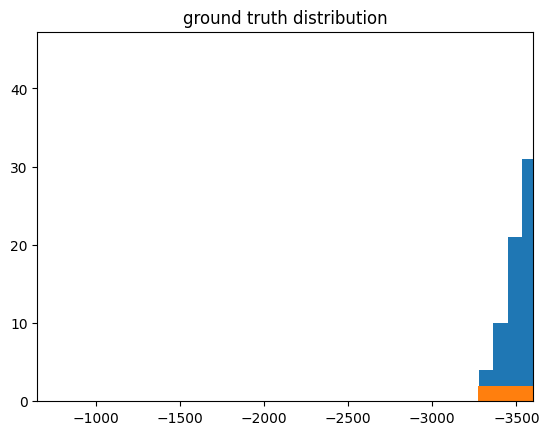

In [7]:
explore_low = True
X_r2,y_r2 =  run(X,y, explore_low)



# Round #2

Key points in the new rounds:

*   CNN model will be retrained
*   all visiting statistics will be reset to zero





Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 200, 128)          512       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 100, 128)          0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 100, 128)          0         
                                                                 
 conv1d_13 (Conv1D)          (None, 100, 64)           24640     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 50, 64)            0         
 g1D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 50, 64)           

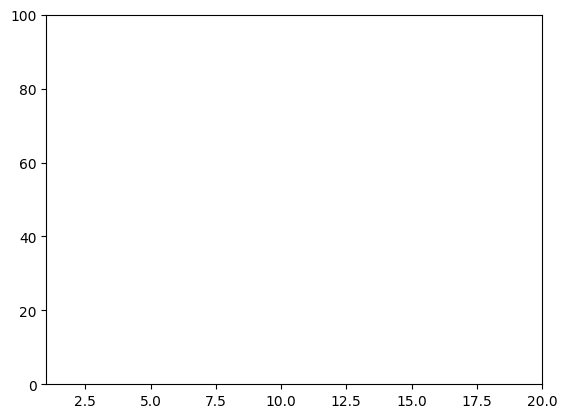

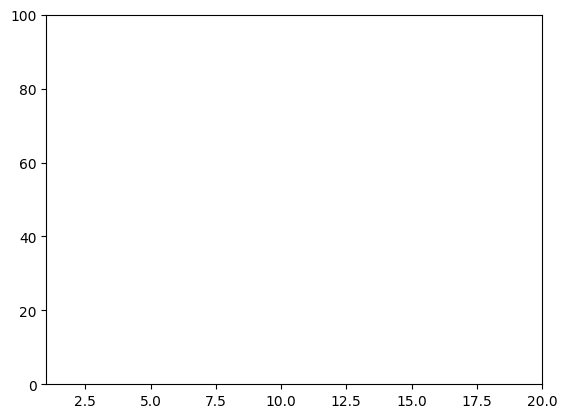

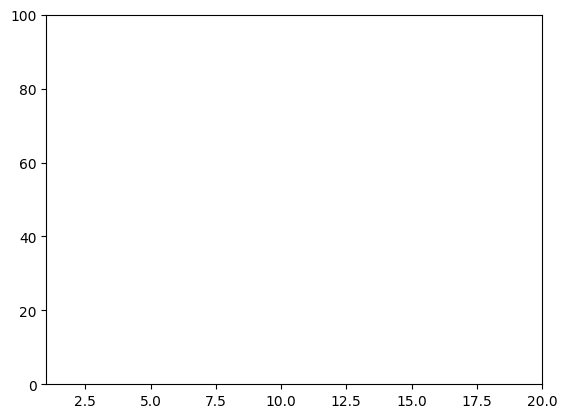

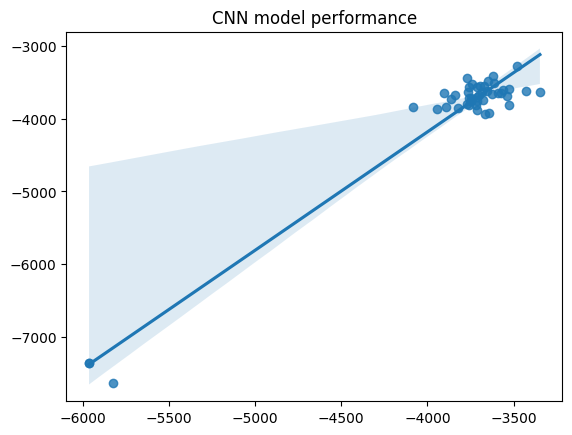

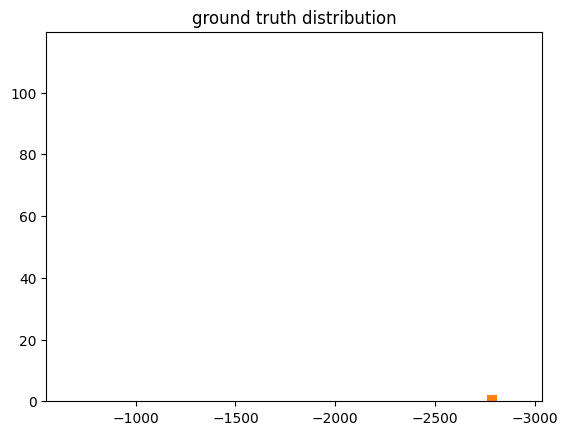

In [8]:
X_r2,y_r2 = run(X_r2,y_r2, explore_low)


## Round #3

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 200, 128)          512       
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 100, 128)          0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 100, 128)          0         
                                                                 
 conv1d_19 (Conv1D)          (None, 100, 64)           24640     
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 50, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 50, 64)           

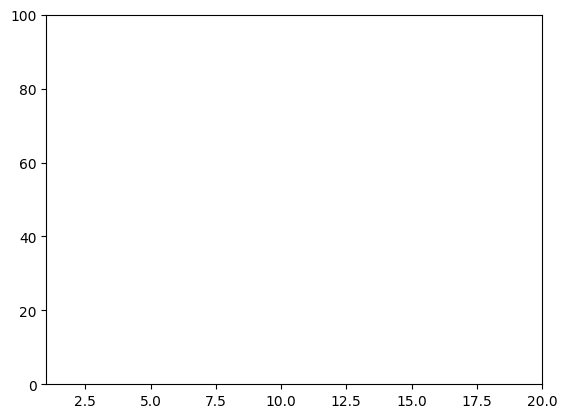

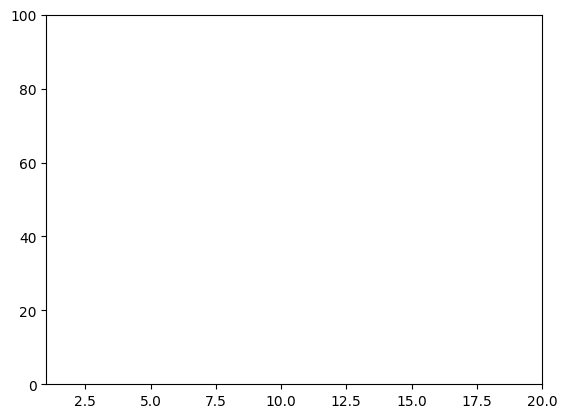

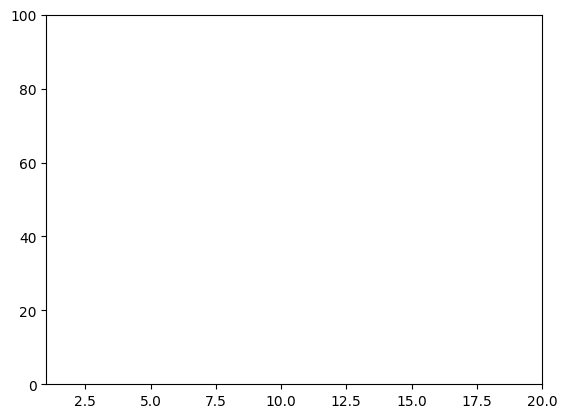

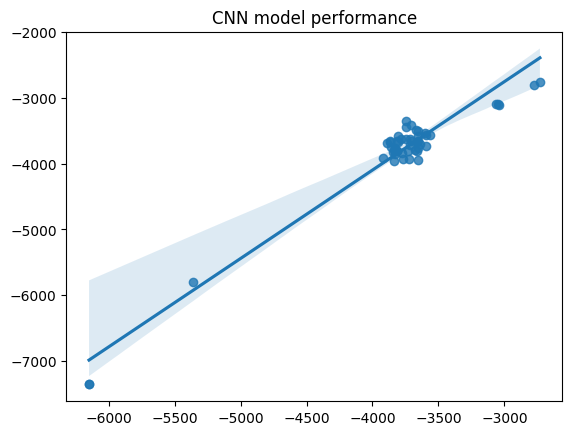

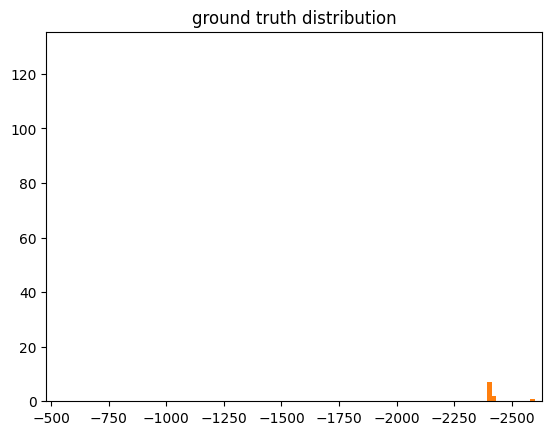

In [9]:
X_r2,y_r2 = run(X_r2,y_r2, explore_low)


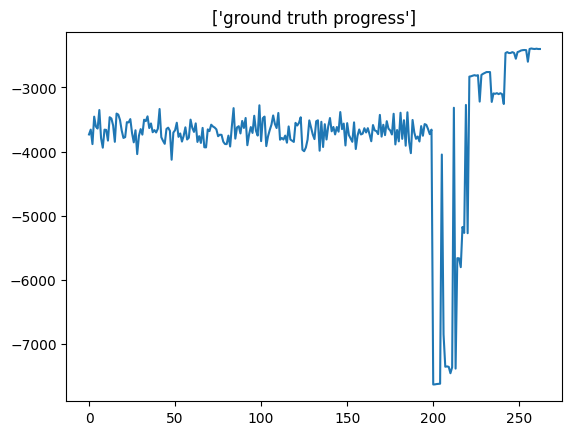

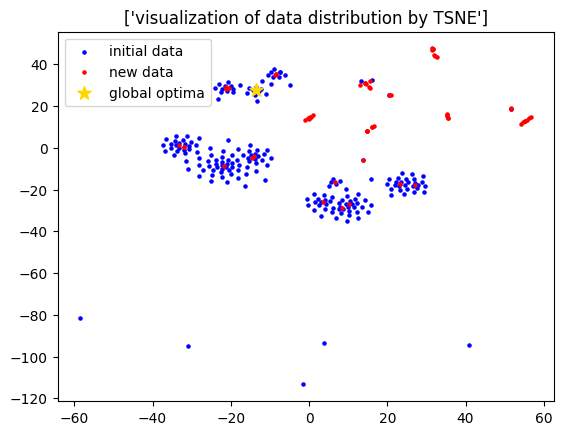

In [15]:
X_new =  X_r2
y_new = y_r2
plt.plot(y_new)
plt.title(['ground truth progress'])
X_new = X_new+np.ones(array_size)
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(X_new)

plt.figure()
plt.scatter(X_embedded[:200,0], X_embedded[:200,1],s=5, color = 'blue')
plt.scatter(X_embedded[200:,0], X_embedded[200:,1],s=5, color = 'red')
plt.scatter(X_embedded[-1,0], X_embedded[-1,1],marker='*',s=100,color = 'gold')
plt.title(['visualization of data distribution by TSNE'])
plt.legend(['initial data','new data','global optima'])